# Video

In ByoTrack videos are expected to be Sequences of frames. We support 2D and 3D videos.

We use numpy to represent frames: each frame is a numpy array of shape ([D, ]H, W, C). The data type can be floating or integer but most of the codes of ByoTrack will expect the frames to be normalized into [0, 1] and we strongly advise to normalize videos.

ByoTrack have its own Video object (*byotrack.Video*) that enables you to read, slice and normalize videos without loading the full video in RAM. In this notebok, we explain how to read, slice, normalize and visualize such Video object in ByoTrack.

**NOTE**: In ByoTrack, the Video object can always be directly replaced by a 4D/5D array (T, [D, ]H ,W, C) or a Sequence of array [([D, ]H, W, C), ...].

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import byotrack
import byotrack.visualize

## Loading videos

A Video can be loaded from a single file (typically mp4 or avi). We support standard format (All those supported by OpenCV) and TIFF stacks.

We also support the loading of multiple files. If you give a folder as input path, ByoTrack will try to infer the list of files by itself. It supports most format of images (png, jpeg, gif, .... and also Tiff stack).

For more complex cases, you can write your own VideoReader following those already implemented or simply load by yourself the video as numpy array.

In [2]:
# Loading a video from a file:

video = byotrack.Video("path/to/video.ext")

if video.ndim == 4:
    print("Video shape: T={}, H={}, W={}, C={}".format(*video.shape, video.channels))
else:
    print("Video shape: T={}, D={}, H={}, W={}, C={}".format(*video.shape, video.channels))

Video shape: T=13, D=126, H=960, W=660, C=2


In [3]:
# Loading a video from a folder:
# ByoTrack will find the most common extension in the folder and expect
# these files to be the images (sorted alphanumerically).

video = byotrack.Video("path/to/images/")

if video.ndim == 4:
    print("Video shape: T={}, H={}, W={}, C={}".format(*video.shape, video.channels))
else:
    print("Video shape: T={}, D={}, H={}, W={}, C={}".format(*video.shape, video.channels))

Video shape: T=1764, H=1010, W=1010, C=1


In [4]:
# Loading a video from a list of files:
# You may also provide the full list of path yourself

video = byotrack.Video(
    "path/to/main_folder",
    paths=[
        "path/to/main_folder/first_frame.png",
        "path/to/main_folder/second_frame.png",
    ],
)


if video.ndim == 4:
    print("Video shape: T={}, H={}, W={}, C={}".format(*video.shape, video.channels))
else:
    print("Video shape: T={}, D={}, H={}, W={}, C={}".format(*video.shape, video.channels))

Video shape: T=2, H=1010, W=1010, C=1


In [5]:
# You can also load example videos provided by ByoTrack (See `byotrack.example_data`)
# Videos are downloaded in a user data folder and then read.

import byotrack.example_data

video = byotrack.example_data.hydra_neurons()  # 2D example

print("Video shape: T={}, H={}, W={}, C={}".format(*video.shape, video.channels))

Video shape: T=1000, H=848, W=1024, C=3


In [6]:
# Let's see the frame shape and dtype

print(video[0].shape, video[0].dtype)

(848, 1024, 3) uint8


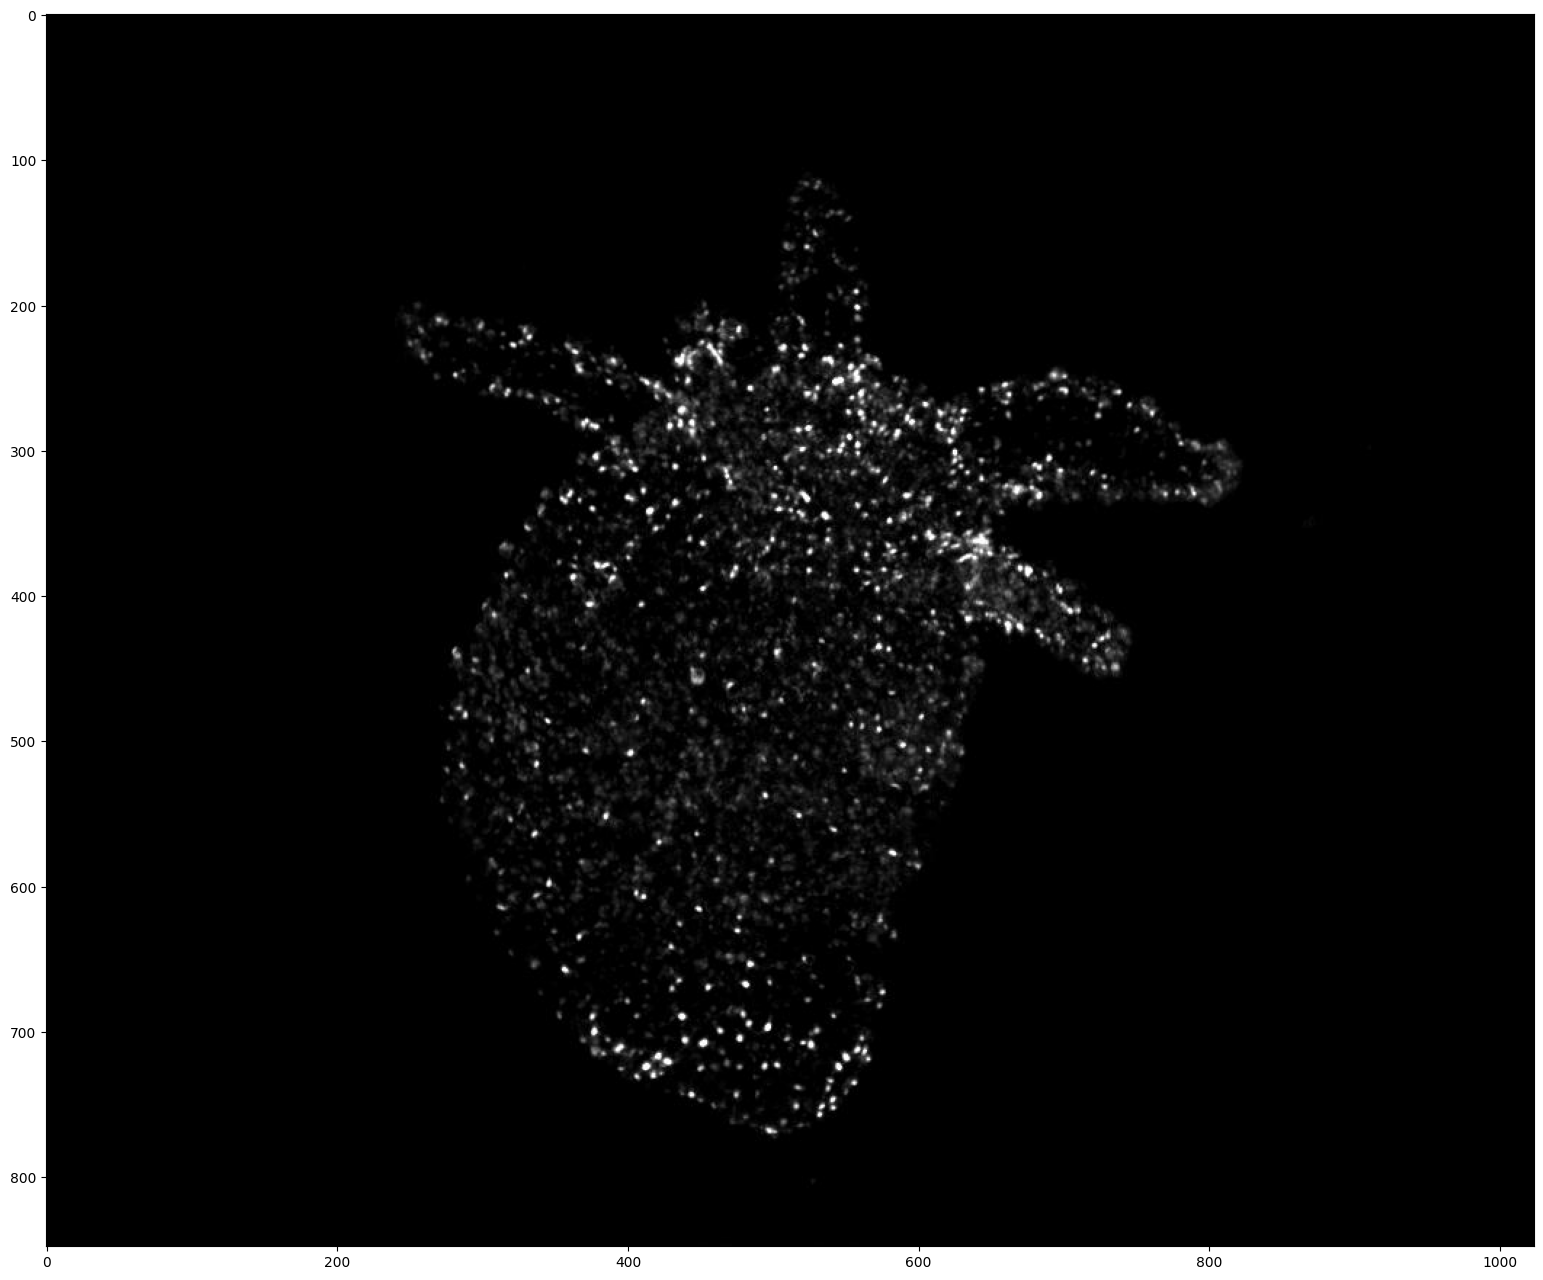

In [7]:
# Display the first frame of a video.
# This may not work for uint16 videos where normalization should be apply before visualization

frame = video[0]
if  video.ndim == 5:  # (T, D, H, W, C) (3D video)
    frame = frame[frame.shape[0] // 2]  # Show the frame in the middle of the stack

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(frame)
plt.show()

## Channel Selection / Normalization

ByoTrack provide some helpers to select and normalize channels in Video objects. It is done on the fly (when frames are required) and it never loads the full video at once.

If your video is not a byotrack.Video but a sequence of arrays (or directly a 4D array), you have to handle normalization on your own.

In [8]:
# See the doc of the Video transformation configuration

byotrack.VideoTransformConfig?

In [9]:
# Define the VideoTransformConfig

transform = byotrack.VideoTransformConfig(
    aggregate=True,  # Aggregate channels into a single one
    normalize=True,  # Normalize the video into [0, 1]
    selected_channel=None,  # None: Average channels, if int, it selects this channel
    q_min=0.02,  # We do not normalize using min and max but rather quantile of the intensity distribution
    q_max=0.999,  # It enforces q_min to go to 0.0 and q_max to go around 1.0 (depending on smooth_clip)
    smooth_clip=0.0,  # Log clipping smoothness for the values that are above q_max (0.0: hard clipping)
    compute_stats_on=10  # Number of frames to read to compute the quantiles. The larger the longer it takes.
)

In [10]:
# Apply the transformation. It may take quite a long time to compute the quantiles.

video.set_transform(transform)

In [11]:
# Let's see the frame shape and dtype. Notice that channel dimension is kept.

print(video[0].shape, video[0].dtype)

(848, 1024, 1) float32


## Temporal and spatial slicing

Video objects allows you to slice temporally and spatially the video. Slicing is data intensive, it just creates a new view on the data without modifying it (it does not even load the data).

In [12]:
# Check the length of the video (number of frames)

len(video)

1000

In [13]:
# Byotrack supports any temporal slicing

# For instance, we slice the first axis (time) using a negative step (the video will be loaded in the reverse order)
# from frame 50 to 0. (51 frames)

len(video[50::-1])

51

In [14]:
# You can also add any positional slicing on the height/width to extract a constant square ROI on the video

# Let's take the frames from 150 to 250 and centered on the middle of the animal

v = video[150:250, 200:-200, 200:-200]
v.shape  # 100 frames of shape (448, 624)

(100, 448, 624)

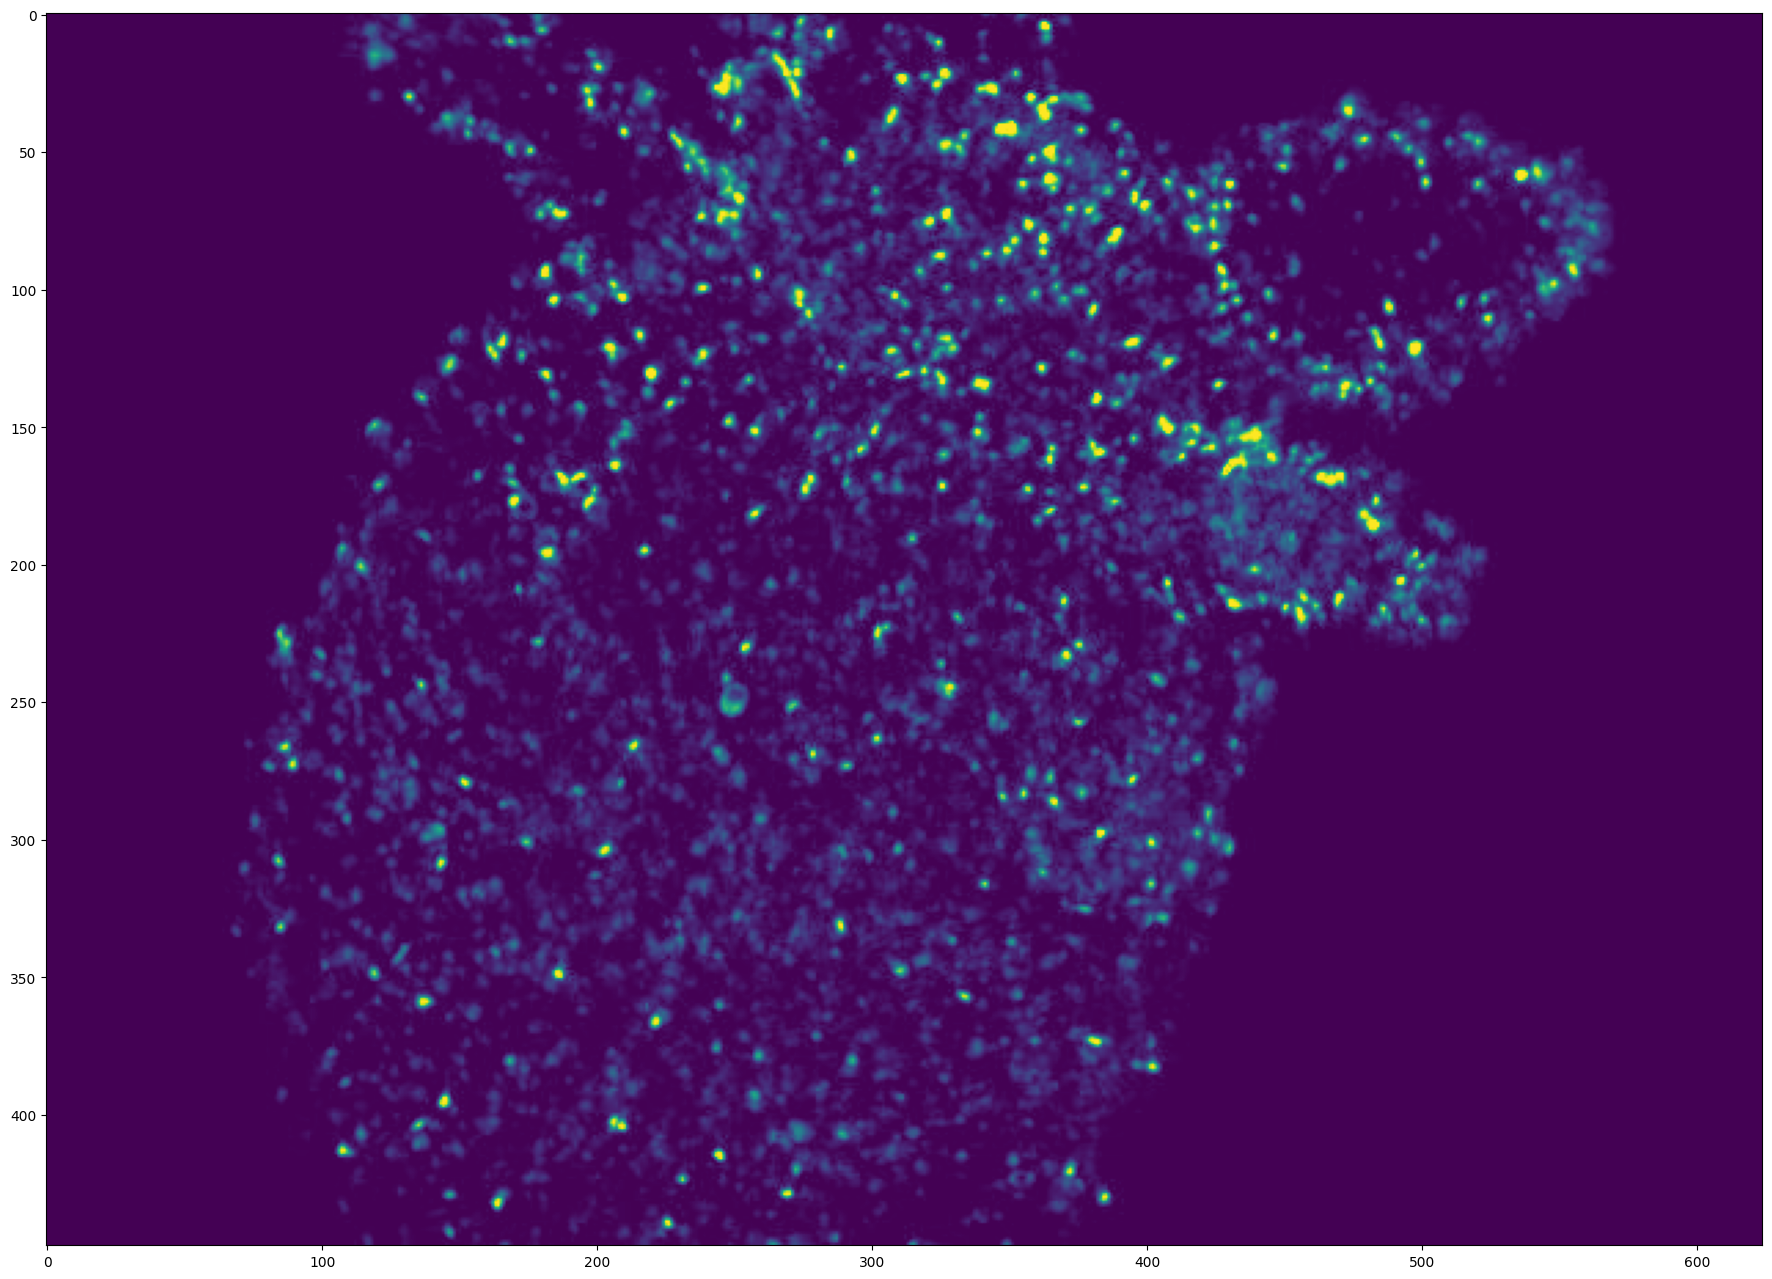

In [15]:
# Display the first frame of this sliced video

frame = v[0]
if  v.ndim == 5:  # (T, D, H, W, C) (3D video)
    frame = frame[frame.shape[0] // 2]  # Show the frame in the middle of the stack

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(frame)
plt.show()

In [16]:
# Compare with frame 150 of the original video

(v[0] == video[150][200:-200,200:-200]).all()

True

## Visualization

We provide an interactive visualization code to go through video, detections and tracks.
It was developped using open-cv and tested on Linux. Depending on the backend opencv uses, it may have different functionnalities (zooming, screenshots, ...)

In [17]:
# Display the video with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use b/n to move inside the stack (For 3D videos)
# Use v to switch on/off the display of the video

byotrack.visualize.InteractiveVisualizer(video).run()

In [18]:
# You can display a sliced video
# First focus on the 300 first frames, then go backward in time (5 frames at a time) and flip the vertical axis

byotrack.visualize.InteractiveVisualizer(video[:300][::-5, ::-1]).run()

## Tiff videos specificities

We support the tiff format for videos. We try to infer axes and shapes from the metadata and what the user is trying to do, but our TiffVideoReader accepts some extra arguments to overwrite this.

Also for large 3D videos, we implemented an on-read slicing, allowing to load only the part of the frame your interested in.

In [19]:
# See the doc of the TiffVideoReader

byotrack.video.reader.TiffVideoReader?

In [20]:
# Overwrite the axis of the tiff stack
# ByoTrack reads the metadata to find the name of each axis. This allows to manually overwrite this behavior.
# We use ImageJ convention for tiff axes: T for time, Z for stack, Y for height, X for width and C/S for channels.
# Most tiff are usually sorted in a TZYX order (without channels)

# Default loading
video = byotrack.Video("path/to/video.tiff")

print("Video shape: T={}, D={}, H={}, W={}, C={}".format(*video.shape, video.channels))

# Let's interpret the first axis as channels no matter the metadata in the tiff.
video = byotrack.Video("path/to/video.tiff", axes="CTZXY")

print("Video shape: T={}, D={}, H={}, W={}, C={}".format(*video.shape, video.channels))

Video shape: T=13, D=126, H=960, W=660, C=2
Video shape: T=126, D=2, H=660, W=960, C=13


In [21]:
# On-read slicing the axis of the tiff stack
# This allows to reduce memory and time consumption for video loading when large frames are involved

# For instance here, we downscale the Z axis by 2, and select only the second channel at read time.
video = byotrack.Video("path/to/video.tiff", ax_slices={"Z": slice(None, None, 2), "C": slice(1, 2)})

print("Video shape: T={}, D={}, H={}, W={}, C={}".format(*video.shape, video.channels))

Video shape: T=13, D=63, H=960, W=660, C=1
